# STAT 301 Project: AIRBNB

 https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities/data?select=london_weekdays.csv

In [115]:

library(dplyr)
library(tidyr)
library(readr)
library(broom)
library(stringr)
library(ggplot2)
library(car)
library(skimr)
library(glmnet)


## 1. Data Set Overview

### Merging Multiple CSV Files and Creating a Day Type Variable

In this step, we merged multiple Airbnb datasets and created a new categorical variable indicating whether each observation comes from a weekday or a weekend.

#### Step-by-step explanation:

1. **File List Definition**  
   We defined a character vector `file_list` that contains the names of six CSV files, representing data from three cities (Barcelona, London, Paris) across both weekdays and weekends.

2. **Reading and Tagging Data**  
   We used `lapply()` to loop through each file name:
   - Each file was read using `read_csv()`.
   - We created a new column `day_type` using `mutate()`, which assigns either `"weekday"` or `"weekend"` depending on whether the file name contains the string `"weekends"`. This was done using `str_detect()` from the `stringr` package.

3. **Merging Datasets**  
   All the data frames were combined into a single data frame `df_all` using `bind_rows()`.

4. **Result Inspection**  
   We used `head(df_all)` to view the first few rows and `summary(df_all)` to examine the summary statistics of the merged dataset.

#### Purpose:
By creating the `day_type` variable directly from the file names, we are able to track which observations came from weekdays and which from weekends. This allows for further grouped analysis and modeling based on day-of-week effects.


In [116]:
file_list <- c("barcelona_weekdays.csv", "barcelona_weekends.csv",
               "vienna_weekdays.csv", "vienna_weekends.csv",
               "paris_weekdays.csv", "paris_weekends.csv")

df_all <- file_list %>%
  lapply(function(file) {
    city <- str_extract(file, "^[a-zA-Z]+") 
    
    read_csv(file) %>%
      mutate(
        day_type = ifelse(str_detect(file, "weekends"), "weekend", "weekday"),
        city = city 
      )
  }) %>%
  bind_rows()




New names:
• `` -> `...1`
Rows: 1555 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 1278 Columns: 20
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): room_type
dbl (16): ...1, realSum, person_capacity, multi, biz, cleanliness_rating, gu...
lgl  (3): room_shared, room_private, host_is_superhost

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 1738 Columns: 20
── Column specification ─────────────────

| Column Name                | Description                                                                          |
|---------------------------|--------------------------------------------------------------------------------------|
| **realSum**               | *The total price of the Airbnb listing.* (Numeric)                                   |
| **room_type**             | *The type of room being offered (e.g. private, shared, etc.).* (Categorical)         |
| **room_shared**           | *Whether the room is shared or not.* (Boolean)                                       |
| **room_private**          | *Whether the room is private or not.* (Boolean)                                      |
| **person_capacity**       | *The maximum number of people that can stay in the room.* (Numeric)                  |
| **host_is_superhost**     | *Whether the host is a superhost or not.* (Boolean)                                  |
| **multi**                 | *Whether the listing is for multiple rooms or not.* (Boolean)                        |
| **biz**                   | *Whether the listing is for business purposes or not.* (Boolean)                     |
| **cleanliness_rating**    | *The cleanliness rating of the listing.* (Numeric)                                   |
| **guest_satisfaction_overall** | *The overall guest satisfaction rating of the listing.* (Numeric)           |
| **bedrooms**              | *The number of bedrooms in the listing.* (Numeric)                                   |
| **dist**                  | *The distance from the city centre.* (Numeric)                                       |
| **metro_dist**            | *The distance from the nearest metro station.* (Numeric)                             |
| **attr_index**            | *An index representing the number and popularity of nearby attractions.* (Numeric)   |
| **attr_index_norm**       | *Normalized version of `attr_index` between 0 and 1.* (Numeric)                      |
| **rest_index**            | *An index representing the number and quality of nearby restaurants.* (Numeric)      |
| **rest_index_norm**       | *Normalized version of `rest_index` between 0 and 1.* (Numeric)                      |
| **lng**                   | *The longitude of the listing.* (Numeric)                                            |
| **lat**                   | *The latitude of the listing.* (Numeric)                                             |
| **day_type**              | *Indicates whether the listing is for a weekday or weekend.* (Categorical)           |
| **city**                  | *The city where the listing is located.* (Categorical)                               |


In [117]:
head(df_all)
n_obs <- nrow(df_all)
n_vars <- ncol(df_all)

cat("Number of observations:", n_obs, "\n")
cat("Number of variables:", n_vars, "\n")


...1,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,⋯,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,day_type,city
<dbl>,<dbl>,<chr>,<lgl>,<lgl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0,474.3175,Entire home/apt,FALSE,FALSE,4,FALSE,0,1,10,⋯,1.111996,0.63049095,526.4694,17.94293,915.5871,20.15489,2.17556,41.39624,weekday,barcelona
1,169.8978,Private room,FALSE,TRUE,2,TRUE,1,0,10,⋯,1.751839,0.12401717,320.1275,10.91046,794.2774,17.48449,2.14906,41.38714,weekday,barcelona
2,161.9848,Private room,FALSE,TRUE,4,FALSE,0,1,9,⋯,1.670493,0.08032198,344.0739,11.72659,840.6736,18.50581,2.15357,41.37859,weekday,barcelona
3,367.9568,Entire home/apt,FALSE,FALSE,3,FALSE,0,1,10,⋯,1.475847,0.09310686,400.0574,13.63460,946.5899,20.83736,2.16839,41.37390,weekday,barcelona
4,196.8953,Private room,FALSE,TRUE,3,FALSE,1,0,9,⋯,1.855452,0.27248605,346.0422,11.79368,792.2960,17.44087,2.15238,41.37699,weekday,barcelona
5,330.9517,Entire home/apt,FALSE,FALSE,3,FALSE,0,1,9,⋯,2.565611,0.70129045,391.0874,13.32889,525.5139,11.56818,2.18197,41.40842,weekday,barcelona


Number of observations: 13058 
Number of variables: 22 


In [118]:
as.data.frame(skim(df_all))

skim_type,skim_variable,n_missing,complete_rate,character.min,character.max,character.empty,character.n_unique,character.whitespace,logical.mean,logical.count,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100,numeric.hist
<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
character,room_type,0,1,11,15,0,3,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
character,day_type,0,1,7,7,0,2,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
character,city,0,1,5,9,0,3,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
logical,room_shared,0,1,NA,NA,NA,NA,NA,0.009342932,"FAL: 12936, TRU: 122",NA,NA,NA,NA,NA,NA,NA,NA
logical,room_private,0,1,NA,NA,NA,NA,NA,0.350742840,"FAL: 8478, TRU: 4580",NA,NA,NA,NA,NA,NA,NA,NA
logical,host_is_superhost,0,1,NA,NA,NA,NA,NA,0.188390259,"FAL: 10598, TRU: 2460",NA,NA,NA,NA,NA,NA,NA,NA
numeric,...1,0,1,NA,NA,NA,NA,NA,NA,NA,1254.0802573,889.1351465,0.000000000,544.0000000,1088.0000000,1740.0000000,3557.000000,▇▇▅▂▂
numeric,realSum,0,1,NA,NA,NA,NA,NA,NA,NA,330.2137784,361.5918133,63.576654279,187.9251104,260.7419144,380.2912372,16445.614689,▇▁▁▁▁
numeric,person_capacity,0,1,NA,NA,NA,NA,NA,NA,NA,2.9879767,1.2472874,2.000000000,2.0000000,2.0000000,4.0000000,6.000000,▇▂▃▁▁


### Splitting data set

In [119]:
set.seed(666)

# Split the data into training (70%), testing (15%), and inference (15%)
df_all <- df_all %>%
  mutate(split = sample(c("training", "testing", "inference"), 
                       size = nrow(df_all), 
                       replace = TRUE, 
                       prob = c(0.7, 0.15, 0.15)))

df_training <- df_all %>% filter(split == "training")
df_testing <- df_all %>% filter(split == "testing")
df_inference <- df_all %>% filter(split == "inference")


table(df_all$split)


inference   testing  training 
     1977      2003      9078 

## Plots

### Comparison of Airbnb Price Distributions (Original vs Log Scale)

The two histograms below compare the distribution of Airbnb listing prices (`realSum`) **before and after log transformation**:

- **Lower plot**: Raw price distribution is **highly right-skewed**, with most listings priced under €200 and a long tail of expensive properties.
- **Upper plot**: Log-transformed prices are **approximately symmetric and bell-shaped**, making them more suitable for linear regression modeling.

> This comparison highlights the **importance of log transformation** when modeling skewed variables like price, as it reduces the impact of extreme values and better satisfies linear model assumptions.


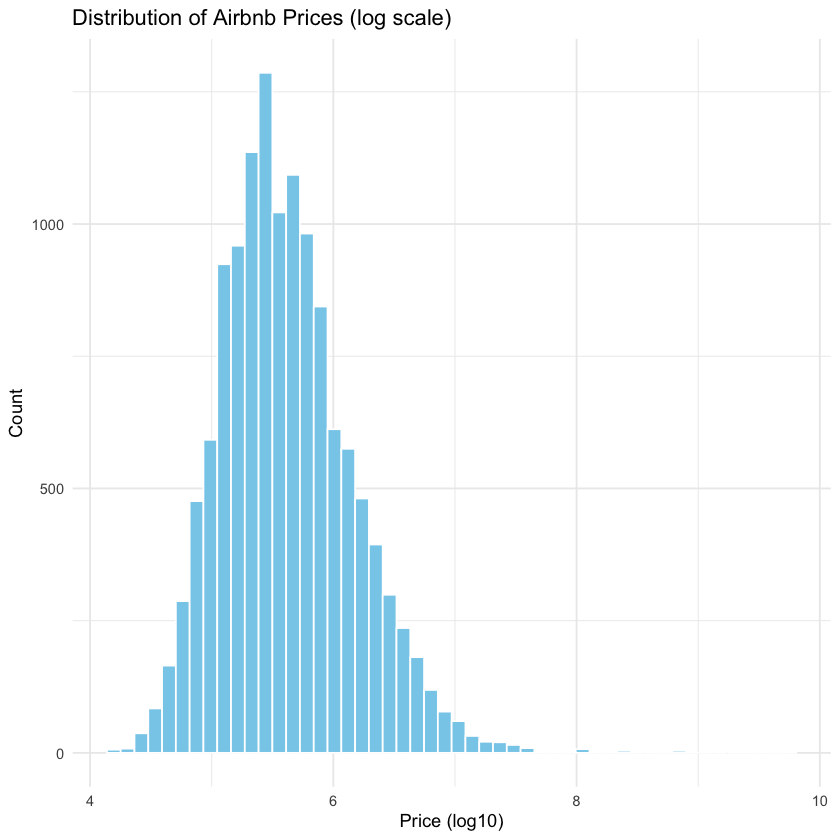

In [120]:
ggplot(df_all, aes(x = log(realSum))) +
  geom_histogram(bins = 50, fill = "skyblue", color = "white") +
  labs(title = "Distribution of Airbnb Prices (log scale)",
       x = "Price (log10)",
       y = "Count") +
  theme_minimal()



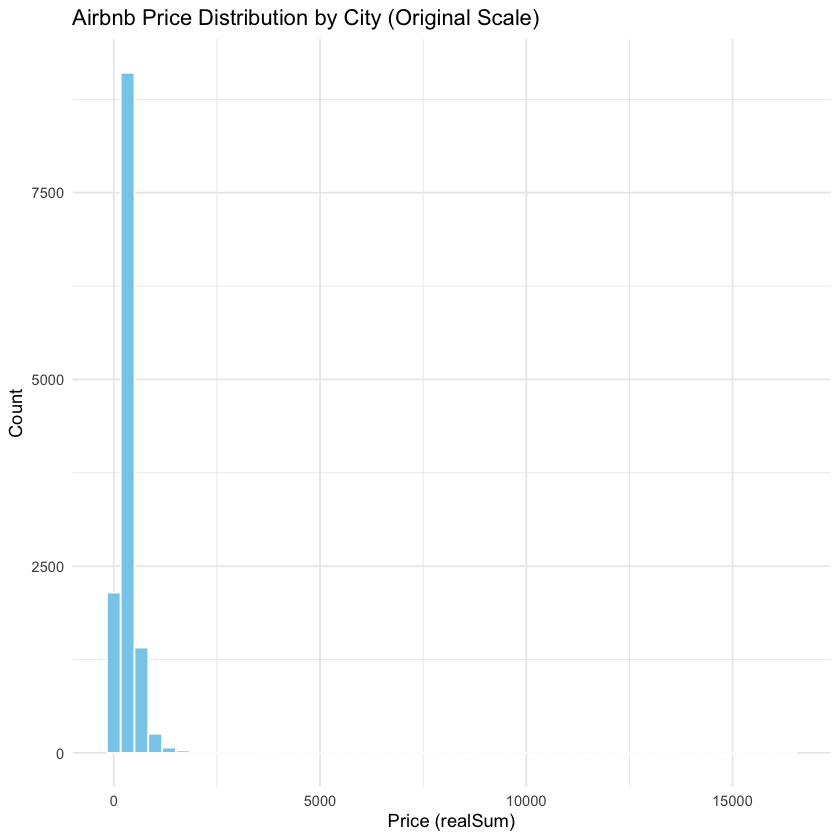

In [121]:
ggplot(df_all, aes(x = realSum)) +
  geom_histogram(bins = 50, fill = "skyblue", color = "white") +
  labs(
    title = "Airbnb Price Distribution by City (Original Scale)",
    x = "Price (realSum)",
    y = "Count"
  ) +
  theme_minimal()

### Distribution by City

### Price by Room Type
Room type may correlated to the price significantly \
This plot shows the distribution of listing prices across different room types. We use a log scale on the y-axis due to the right-skewed distribution of prices.


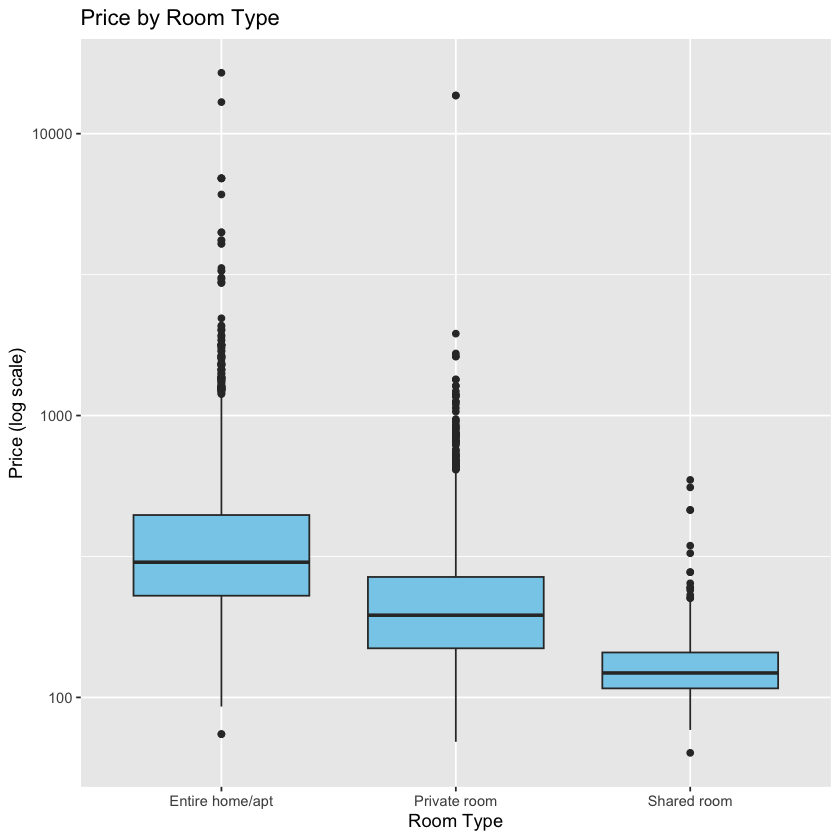

In [122]:
ggplot(df_all, aes(x = room_type, y = realSum)) +
  geom_boxplot(fill = "skyblue") +
  scale_y_log10() +
  labs(title = "Price by Room Type", x = "Room Type", y = "Price (log scale)")


### Price by Distance from City Centre,for different day type

It is intuitive that listings closer to the city centre tend to be more expensive due to higher demand and convenience.  
However, the visualizations indicate that the relationship between distance and price may be **nonlinear**.


`geom_smooth()` using method = 'gam' and formula = 'y ~ s(x, bs = "cs")'


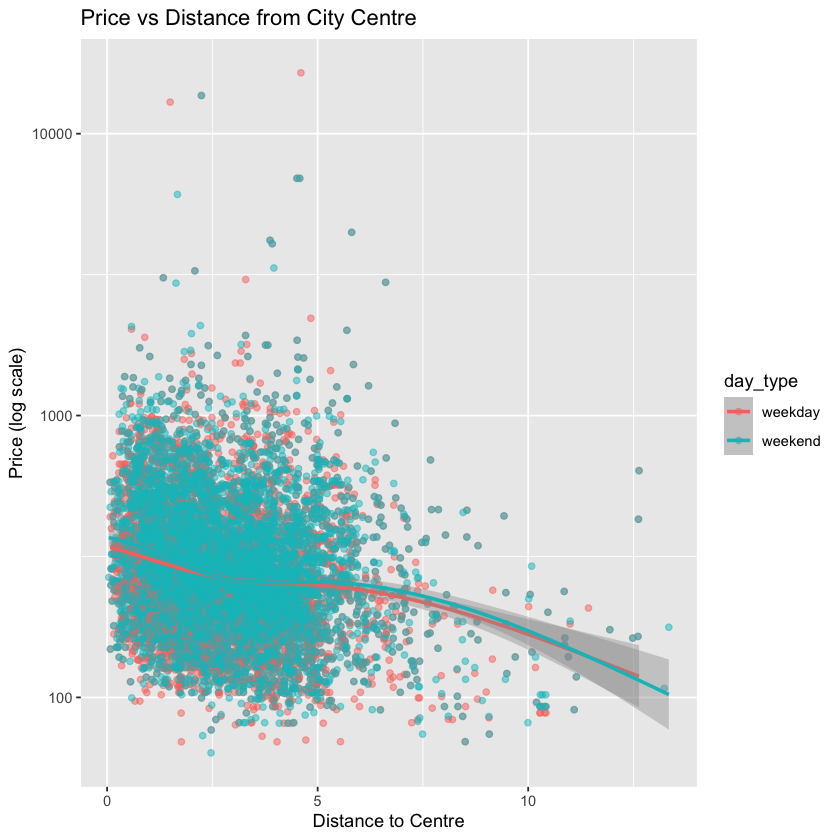

In [123]:
ggplot(df_all, aes(x = dist, y = realSum, color = day_type)) +
  geom_point(alpha = 0.5) +
  geom_smooth() +  
  scale_y_log10() +
  labs(title = "Price vs Distance from City Centre",
       x = "Distance to Centre", y = "Price (log scale)")



## Price Distribution by Day Type

We hypothesize that **Airbnb listing prices may vary between weekdays and weekends** due to differences in demand:

- **On weekends**, people are more likely to travel for leisure or short vacations, which can drive up demand and lead to higher prices.
- **On weekdays**, bookings are more likely to come from business travelers, with potentially lower or more consistent pricing, especially in cities with high business activity.
- However, the mean is so close that may be not significant.

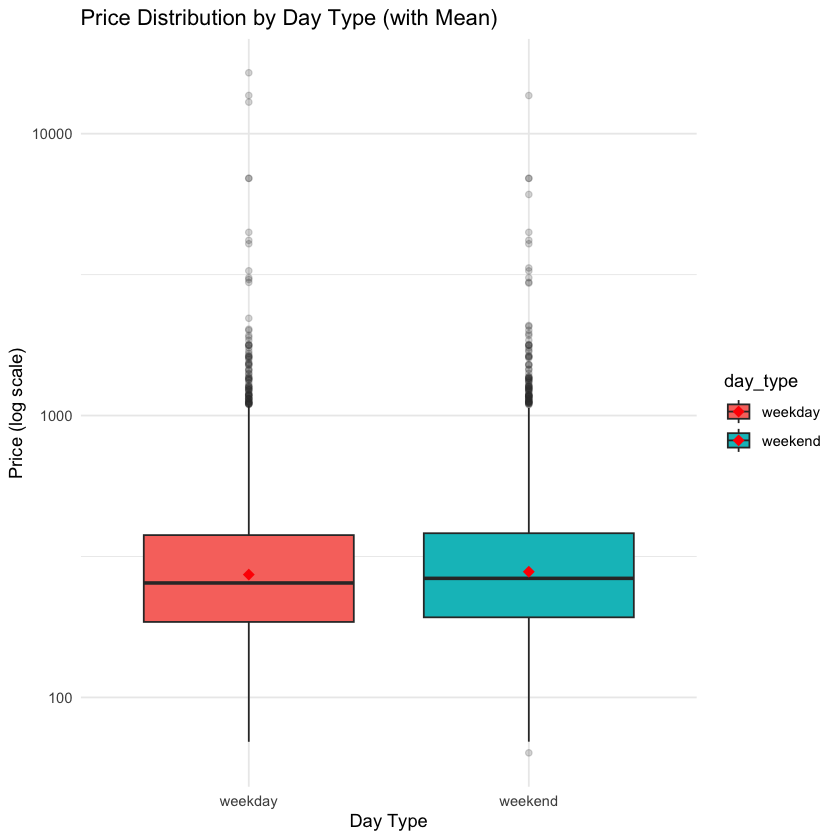

In [124]:
ggplot(df_all, aes(x = day_type, y = realSum, fill = day_type)) +
  geom_boxplot(outlier.alpha = 0.2) +
  stat_summary(fun = mean, geom = "point", shape = 18, size = 3, color = "red") +
  scale_y_log10() +
  labs(title = "Price Distribution by Day Type (with Mean)",
       x = "Day Type", y = "Price (log scale)") +
  theme_minimal()


### Price Distribution by Person Capacity (Boxplot, log scale)

The boxplot below displays the distribution of Airbnb prices (log-transformed) across different levels of `person_capacity` (the maximum number of people a listing can accommodate). Each box represents the interquartile range (IQR) for listings that can host a specific number of guests.

> This plot helps us understand how the number of guests a listing can accommodate relates to price, and motivates including `person_capacity` in our predictive model, potentially with interaction or nonlinear terms.

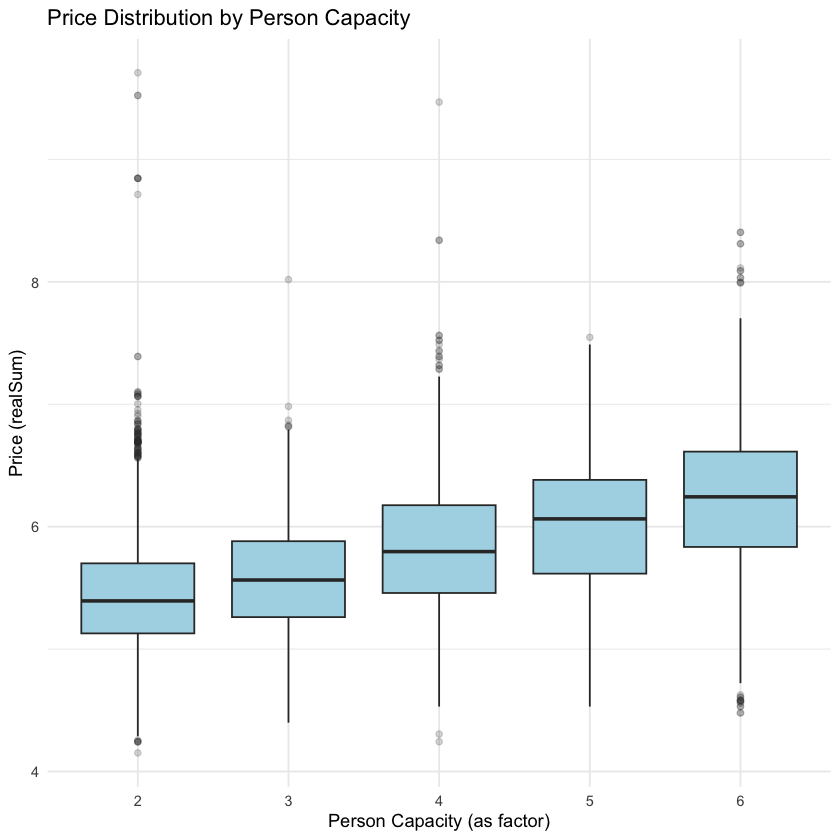

In [125]:
ggplot(df_all, aes(x = factor(person_capacity), y = log(realSum))) +
  geom_boxplot(fill = "lightblue", outlier.alpha = 0.2) +
  labs(
    title = "Price Distribution by Person Capacity",
    x = "Person Capacity (as factor)",
    y = "Price (realSum)"
  ) +
  theme_minimal()



## Price vs Cleanliness Rating 

Observations on Price vs Cleanliness Rating

Although the boxplot shows that **median prices are relatively stable** across different cleanliness ratings, an interesting pattern emerges at the upper end of the price range:

- **High-price outliers** are more frequent among listings with high cleanliness scores (especially 9 and 10).
- This suggests that cleanliness may not significantly influence the **average price**, but could be an important attribute for **high-end or luxury listings**.
- In contrast, listings with low cleanliness scores rarely command high prices, indicating a potential ceiling effect at low ratings.

> These findings imply that while `cleanliness_rating` may have limited explanatory power for typical listings, it could be useful in identifying or modeling the upper tail of the price distribution.


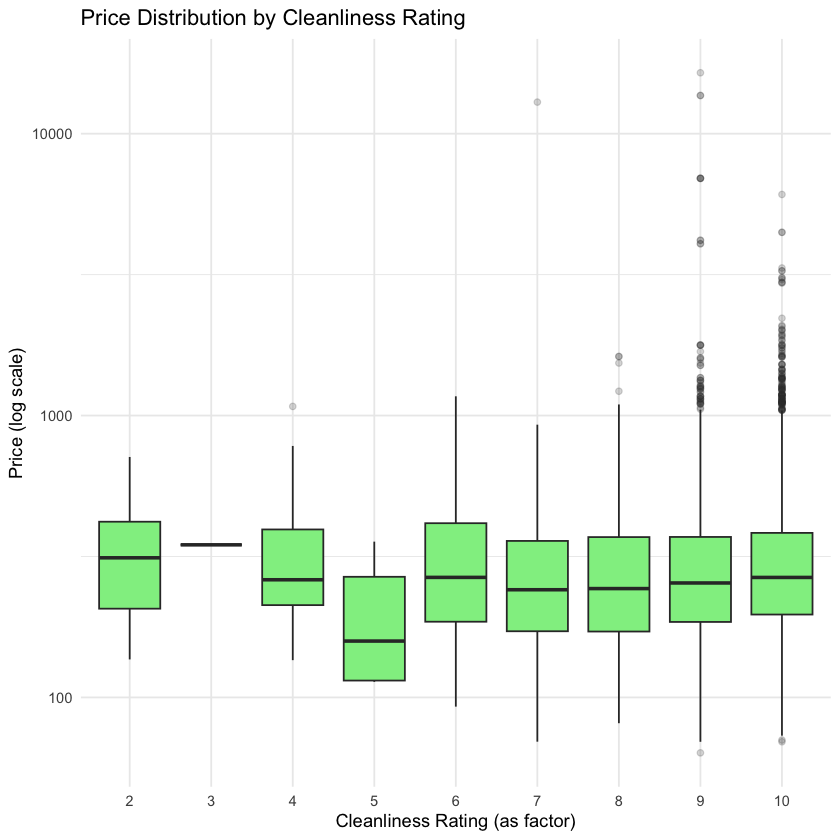

In [126]:
ggplot(df_all, aes(x = factor(cleanliness_rating), y = realSum)) +
  geom_boxplot(fill = "lightgreen", outlier.alpha = 0.2) +
  scale_y_log10() +
  labs(
    title = "Price Distribution by Cleanliness Rating",
    x = "Cleanliness Rating (as factor)",
    y = "Price (log scale)"
  ) +
  theme_minimal()




### Research Question

**Question:**  
How do room characteristics, location features, and customer ratings affect Airbnb listing prices in major European cities?

**Response Variable:**  
- `log(realSum)` — the natural logarithm of the total price of the Airbnb listing.  
  (We use log-transformed price to address skewness and stabilize variance.)

**Explanatory Variables:**  
- `room_type` (categorical: entire, private, shared)
- `bedrooms`, `person_capacity` (room size and capacity)
- `cleanliness_rating` and its square (nonlinear rating effect)
- `guest_satisfaction_overall` and its square (nonlinear guest perception)
- `day_type` (weekday vs weekend)
- `dist` and `metro_dist`, and their squares (nonlinear location effects)
- `attr_index_norm`, `rest_index_norm` (normalized neighborhood amenities)
- Interaction terms: `room_type * bedrooms`, `room_type * person_capacity`, `day_type * person_capacity`

**Purpose:**  
Our goal is both **inference** and **prediction**:
- **Inference:** Identify which variables significantly affect listing prices and interpret their relationships.
- **Prediction:** Develop a regression model that can predict Airbnb listing prices from room and location features.

The dataset contains hundreds of observations from multiple cities, with detailed listing and location attributes. This richness allows us to examine price behavior across different market segments and understand the drivers of pricing.


### Model Assumptions AND Planning

To apply linear regression, we assume:

1. **Linearity in parameters**:  
   The model assumes that the outcome (here, log-transformed price) is a linear function of the **parameters**.  
   Note that this does **not** require that the relationship between predictors and the response be strictly linear.  
   For example, by including **polynomial terms** (e.g., `cleanliness_rating^2`, `dist^2`) and **interactions** (e.g., `room_type * bedrooms`), we allow the model to capture **nonlinear** or **conditional effects** while maintaining a linear structure in coefficients.

2. **Independence**:  
   The observations are assumed to be independent. This may be violated if there are clusters (e.g., listings from the same host or neighborhood).

3. **Homoscedasticity**:  
   The variance of residuals is assumed constant across all levels of the predictors.  
   We partially address this with a log transformation of the response variable.

4. **Normality of residuals**:  
   For inference purposes, we assume that residuals are approximately normally distributed.  
   This assumption becomes less critical when the focus is prediction, or when using large sample sizes.

5. **No perfect multicollinearity**:  
   Predictors must not be exact linear combinations of each other.  
   This can be checked using variance inflation factors (VIF).

### Proposed Method: Multiple Linear Regression with Transformations and Interactions

We propose using a **multiple linear regression model** on the log-transformed price, with polynomial and interaction terms.

#### Why this method is appropriate:
- It allows for **interpretability**: coefficients can be interpreted as percentage effects on price.
- The **log transformation** helps address **skewed price distribution** and **heteroscedasticity**.
- By including **quadratic terms**, we capture **nonlinear relationships** (e.g., diminishing effects).
- Interaction terms allow modeling **heterogeneous effects** (e.g., the effect of bedrooms may differ by room type).
- Regression provides tools for **inference** (significance testing, confidence intervals) and **prediction** (fitted values, cross-validation).



## Model Build First Try (No Interaction Model，NO Log)

### Model Specification and Hypotheses

We propose the following additive linear regression model to examine how room characteristics, guest satisfaction, and location features affect Airbnb listing prices.

#### Model Expression

Let  
- \( Y_i \) be the total price (`realSum`) of listing \( i \)

The model is expressed as:

$$
Y_i = \beta_0 + \beta_1 \cdot \text{room\_type}_i + \beta_2 \cdot \text{person\_capacity}_i + \beta_3 \cdot \text{cleanliness\_rating}_i + \beta_4 \cdot \text{guest\_satisfaction\_overall}_i + \beta_5 \cdot \text{day\_type}_i + \beta_6 \cdot \text{dist}_i + \beta_7 \cdot \text{metro\_dist}_i + \varepsilon_i
$$

Where:

- \( \beta_0 \) is the intercept  
- \( \beta_1, \dots, \beta_7 \) are the coefficients to be estimated  
- \( \varepsilon_i \sim \mathcal{N}(0, \sigma^2) \) is the error term

Note:

- `room_type` and `day_type` are categorical variables and will be dummy-coded.  
- All other predictors are treated as continuous.

---

### Hypothesis Testing

For each coefficient \( \beta_j \), we test the following hypotheses:

$$
\begin{aligned}
H_0 &: \beta_j = 0 \quad \text{(no effect on price)} \\
H_A &: \beta_j \ne 0 \quad \text{(significant effect on price)}
\end{aligned}
$$

This hypothesis test helps determine whether each predictor has a statistically significant relationship with the listing price, after controlling for other variables in the model.



In [127]:
model_addtive_full <- lm(realSum ~room_type + person_capacity + cleanliness_rating + guest_satisfaction_overall + day_type + dist+ city + metro_dist,df_training)

In [128]:
model_addtive_full_result <- tidy(model_addtive_full)|>mutate(across(where(is.numeric), ~ round(.x, 4)))
model_addtive_full_result

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-32.0201,37.9139,-0.8445,0.3984
room_typePrivate room,-54.5243,8.2668,-6.5956,0.0000
room_typeShared room,-237.9813,31.6374,-7.5221,0.0000
person_capacity,81.3731,2.7633,29.4479,0.0000
cleanliness_rating,20.4825,4.3605,4.6973,0.0000
guest_satisfaction_overall,-0.0368,0.4967,-0.0742,0.9409
day_typeweekend,0.5886,6.2241,0.0946,0.9247
dist,-16.3999,2.1806,-7.5208,0.0000
cityparis,59.0697,9.9451,5.9396,0.0000


### Residual Plot Diagnostic: Observed Issues

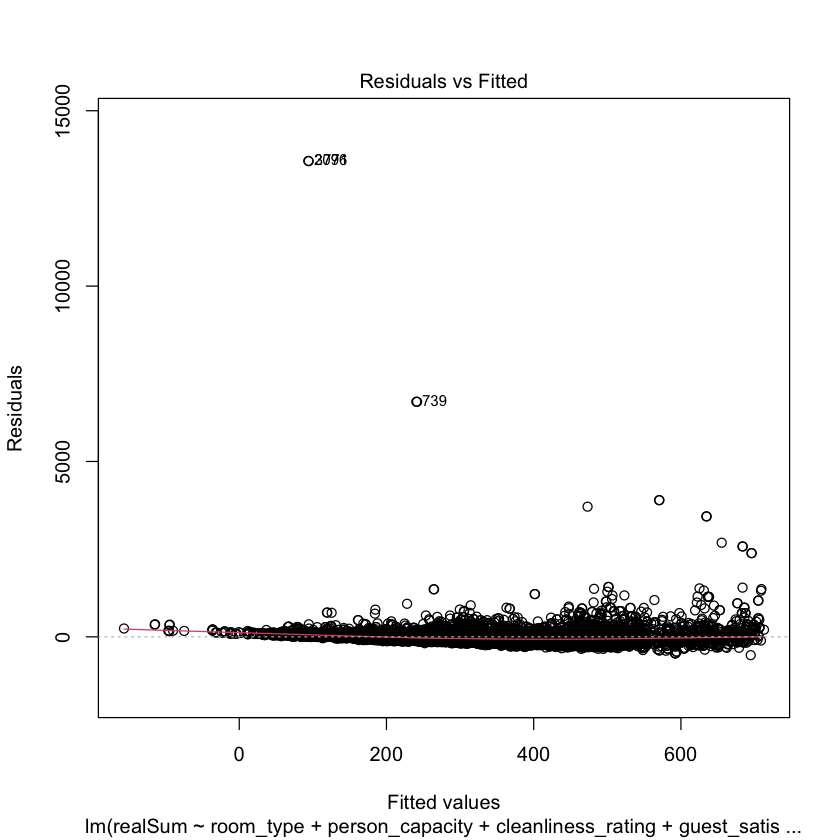

In [129]:
plot(model_addtive_full, which = 1)

#### Key Observations

1. **Non-random Residual Pattern**:  
   The residuals are not randomly scattered around the horizontal axis. Instead, they appear to fan out and increase as the fitted values increase.

2. **Heteroscedasticity**:  
   The variance of residuals is clearly not constant. As fitted values increase, the spread of residuals becomes wider, violating the constant variance (homoscedasticity) assumption of linear regression.

3. **Non-centered Residuals**:  
   Most residuals lie above zero, indicating a possible bias in the model where it systematically underpredicts prices for some listings.

4. **Outliers**:  
   Several points have extreme residuals (e.g., above 10,000), which may strongly influence the model and distort inference.

#### Implications

- These issues suggest that the assumptions of the linear regression model are violated.
- Specifically, the presence of heteroscedasticity and outliers can lead to:
  - Biased or inefficient coefficient estimates.
  - Invalid standard errors and hypothesis tests.
- The residuals also suggest a non-linear relationship or misspecification in the model.

#### Next Steps

To address these issues, we may consider:
- Applying a log-transformation to the response variable (`realSum`).

## log-transformation Model

### Model Specification

We fit a **log-linear multiple regression model** to explore the nonlinear and interaction effects of various Airbnb listing features on the log-transformed total price (`log(realSum)`).

#### Model Formula

Let \( Y_i = \log(\text{realSum}_i) \), then the model is:

\[
\begin{aligned}
Y_i =\ & \beta_0 + \beta_1 \cdot \text{bedrooms}_i \\
&+ \beta_2 \cdot \text{room\_type}_i + \beta_3 \cdot \text{person\_capacity}_i + \beta_4 \cdot (\text{room\_type}_i \times \text{person\_capacity}_i) \\
&+ \beta_5 \cdot \text{city}_i \\
&+ \beta_6 \cdot \text{cleanliness\_rating}_i + \beta_7 \cdot \text{cleanliness\_rating}_i^2 \\
&+ \beta_8 \cdot \text{guest\_satisfaction\_overall}_i + \beta_9 \cdot \text{guest\_satisfaction\_overall}_i^2 \\
&+ \beta_{10} \cdot \text{day\_type}_i + \beta_{11} \cdot (\text{day\_type}_i \times \text{person\_capacity}_i) \\
&+ \beta_{12} \cdot \text{dist}_i + \beta_{13} \cdot \text{dist}_i^2 \\
&+ \beta_{14} \cdot \text{metro\_dist}_i + \beta_{15} \cdot \text{metro\_dist}_i^2 \\
&+ \beta_{16} \cdot \text{attr\_index\_norm}_i + \beta_{17} \cdot \text{rest\_index\_norm}_i + \varepsilon_i
\end{aligned}
\]

Where:

- \( \varepsilon_i \sim N(0, \sigma^2) \) is the error term  
- Categorical variables (`room_type`, `city`, `day_type`) are coded using dummy variables  
- \( \log(\text{realSum}) \) ensures that the predicted price remains strictly positive and helps stabilize variance

#### Features of the Model

- Includes **polynomial terms** (squared) to capture potential nonlinear effects (e.g., diminishing or increasing marginal returns)
- Includes **interaction terms** between `room_type` and `person_capacity`, as well as between `day_type` and `person_capacity`, to model conditional effects
- Incorporates **log-transformed response variable** to account for skewness in pricing
- Applies **city-level fixed effects** to control for baseline price differences across locations (Paris, Vienna, Barcelona)

This model balances interpretability with flexibility, enabling nuanced insights into how listing characteristics affect Airbnb pricing.



In [130]:
model_log <- lm(log(realSum) ~ 
                         bedrooms + 
                         room_type * person_capacity + 
                         city+
                         cleanliness_rating + I(cleanliness_rating^2) + 
                         guest_satisfaction_overall + I(guest_satisfaction_overall^2) + 
                         day_type * person_capacity + 
                         dist + I(dist^2) + 
                         metro_dist + I(metro_dist^2) + 
                         attr_index_norm + rest_index_norm,
                         data =df_training)


In [131]:
model_log_result <- tidy(model_log)|>mutate(across(where(is.numeric), ~ round(.x, 4)))
model_log_result

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),5.8305,0.1293,45.0758,0.0000
bedrooms,0.1641,0.0076,21.6271,0.0000
room_typePrivate room,-0.3060,0.0268,-11.4331,0.0000
room_typeShared room,-0.3055,0.0882,-3.4625,0.0005
person_capacity,0.1328,0.0053,24.8501,0.0000
cityparis,0.0305,0.0188,1.6223,0.1048
cityvienna,-0.2139,0.0132,-16.2282,0.0000
cleanliness_rating,-0.0358,0.0338,-1.0578,0.2902
I(cleanliness_rating^2),0.0058,0.0020,2.8526,0.0043


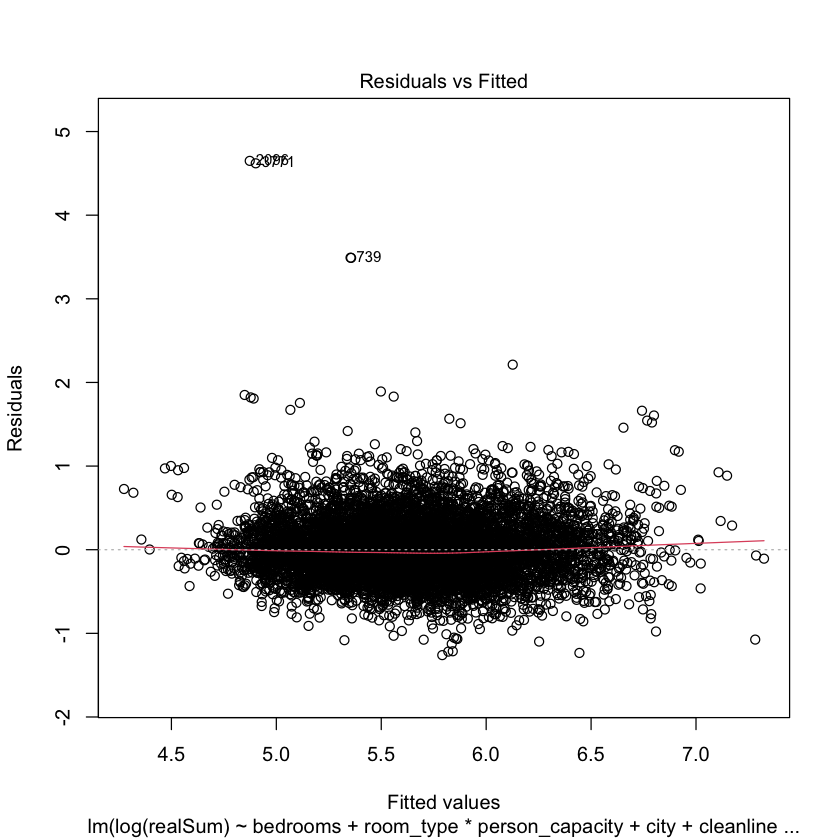

In [132]:
plot(model_log, which = 1)

### ANOVA: Model Refinement Evaluation

In [133]:
model_log_refine_no2 <- lm(log(realSum) ~ 
                         bedrooms + 
                         room_type * person_capacity + 
                         city+
                         cleanliness_rating + 
                         guest_satisfaction_overall + 
                         day_type * person_capacity + 
                         dist +
                         metro_dist + 
                         attr_index_norm + rest_index_norm,
                         data =df_training)

In [134]:
anova(model_log_refine_no2,model_log)|>mutate(across(where(is.numeric), ~ round(.x, 4)))
summary(model_log_refine_no2)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,9061,1139.780,NA,NA,NA,NA
2,9057,1121.263,4,18.5173,37.3934,0



Call:
lm(formula = log(realSum) ~ bedrooms + room_type * person_capacity + 
    city + cleanliness_rating + guest_satisfaction_overall + 
    day_type * person_capacity + dist + metro_dist + attr_index_norm + 
    rest_index_norm, data = df_training)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2515 -0.2289 -0.0350  0.1892  4.6068 

Coefficients:
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                            4.4416891  0.0487137  91.179  < 2e-16
bedrooms                               0.1695099  0.0076320  22.210  < 2e-16
room_typePrivate room                 -0.3027376  0.0269558 -11.231  < 2e-16
room_typeShared room                  -0.3127056  0.0889346  -3.516  0.00044
person_capacity                        0.1297616  0.0053781  24.128  < 2e-16
cityparis                              0.0288512  0.0181244   1.592  0.11146
cityvienna                            -0.2083355  0.0131620 -15.829  < 2e-16
cleanliness_rating     


We compared two nested models using ANOVA:

- **Reduced Model**: Removed all quadratic terms (no squared predictors)
- **Full Model**: Included quadratic terms for `cleanliness_rating`, `guest_satisfaction_overall`, `dist`, and `metro_dist`

#### Results:

| Statistic | Value     |
|-----------|-----------|
| Degrees of Freedom Difference | 4       |
| F-statistic                   | 84.68   |
| p-value                       | < 0.0001|

#### Interpretation:

The very low p-value indicates that the full model with quadratic terms provides a **significantly better fit** than the reduced model. Thus, we retain the squared terms to capture non-linear effects of cleanliness, guest satisfaction, and distance on log(price).

Including these higher-order terms enhances model accuracy and reflects the real-world intuition that effects may not be strictly linear.


### Lasso model covar

#### Model fomula

In [135]:
design_formula <- ~ 
  bedrooms + 
  room_type * person_capacity + 
  city +
  cleanliness_rating + I(cleanliness_rating^2) + 
  guest_satisfaction_overall + I(guest_satisfaction_overall^2) + 
  day_type * person_capacity + 
  dist + I(dist^2) + 
  metro_dist + I(metro_dist^2) + 
  attr_index_norm + rest_index_norm - 1  


In [136]:
x_train <- model.matrix(design_formula, data = df_training)
y_train <- log(df_training$realSum)

In [ ]:
set.seed(123)
lasso_cv <- cv.glmnet(
  x = x_train,
  y = y_train,
  family = "gaussian",
  alpha  = 1,       
  nfolds = 10
)

In [145]:

coef_min  <- coef(lasso_cv, s = "lambda.min")
coef_1se  <- coef(lasso_cv, s = "lambda.1se")
pred_train_min <- predict(lasso_cv, newx = x_train, s = "lambda.min")

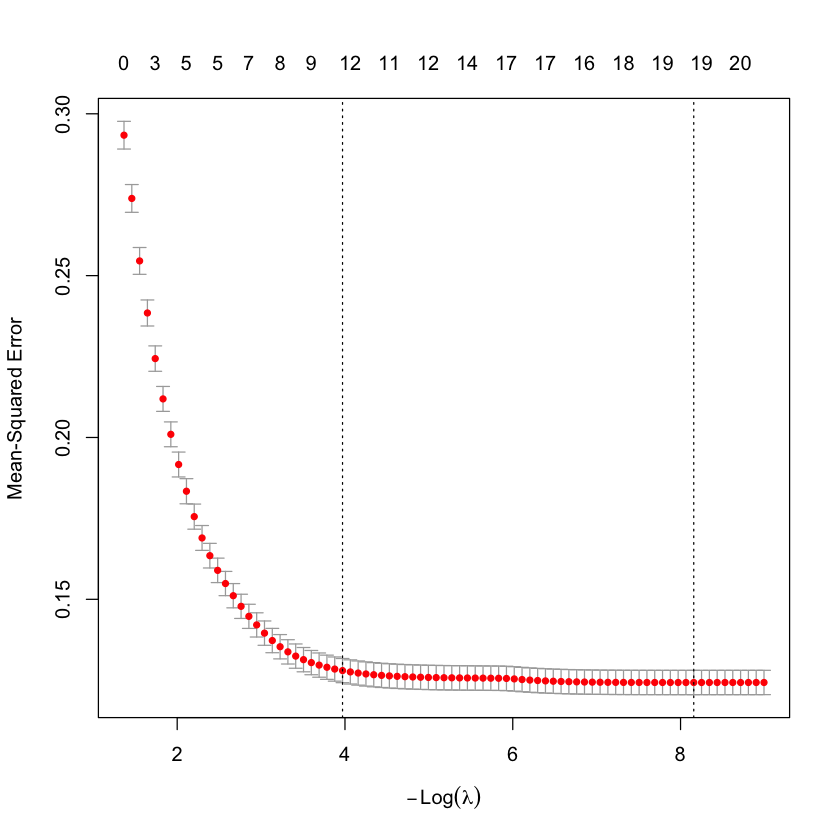

In [144]:

plot(lasso_cv)
abline(v = log(lasso_cv$lambda.min),  lty = 2)
abline(v = log(lasso_cv$lambda.1se),  lty = 3)


In [146]:
coef_min

22 x 1 sparse Matrix of class "dgCMatrix"
                                         lambda.min
(Intercept)                            5.3554445086
bedrooms                               0.1639001165
room_typeEntire home/apt               0.2944429634
room_typePrivate room                  .           
room_typeShared room                  -0.0088230824
person_capacity                        0.1329920520
cityparis                              0.0269659277
cityvienna                            -0.2120364486
cleanliness_rating                    -0.0157921524
I(cleanliness_rating^2)                0.0045796598
guest_satisfaction_overall            -0.0252096863
I(guest_satisfaction_overall^2)        0.0001510166
day_typeweekend                        0.0165121158
dist                                  -0.0043741430
I(dist^2)                              .           
metro_dist                             0.0133282007
I(metro_dist^2)                       -0.0203740461
attr_index_norm       


### LASSO Coefficients at `lambda.min`

| Variable                              | Coefficient |
|---------------------------------------|-------------|
| **(Intercept)**                       | 5.3554      |
| **bedrooms**                          | 0.1639      |
| **room_typeEntire home/apt**          | 0.2944      |
| room_typePrivate room                 | —           |
| **room_typeShared room**              | -0.0088     |
| **person_capacity**                   | 0.1330      |
| **cityparis**                         | 0.0270      |
| **cityvienna**                        | -0.2120     |
| **cleanliness_rating**                | -0.0158     |
| **I(cleanliness_rating²)**            | 0.0046      |
| **guest_satisfaction_overall**        | -0.0252     |
| **I(guest_satisfaction_overall²)**    | 0.000151    |
| **day_typeweekend**                   | 0.0165      |
| **dist**                              | -0.0044     |
| I(dist²)                              | —           |
| **metro_dist**                        | 0.0133      |
| **I(metro_dist²)**                    | -0.0204     |
| **attr_index_norm**                   | 0.0114      |
| **rest_index_norm**                   | 0.0055      |
| **room_typePrivate room:person_capacity** | 0.0023  |
| **room_typeShared room:person_capacity**  | -0.1592 |
| **person_capacity:day_typeweekend**   | 0.0057      |

**Notes**:
- “—” indicates that the coefficient was shrunk to zero by LASSO (variable not retained in the model).
- Categorical variables (dummy variables) are coded relative to a **reference category** (baseline).  
  In this output, the **baseline** for `room_type` is *Private room* and for `city` is *Barcelona*.  
  This means:
  - Coefficients for `room_typeEntire home/apt` and `room_typeShared room` are interpreted relative to *Private room*.  
  - Coefficients for `cityparis` and `cityvienna` are interpreted relative to *Barcelona*.
- Because **LASSO penalizes each dummy column separately**, it can keep some categories and drop others, which may lead to **interpretation challenges**:
  - The model might retain one category of a factor while shrinking another to zero, breaking the “whole variable” interpretation.
  - Effects for omitted categories are absorbed into the baseline, making cross-category comparisons less straightforward.
- Coefficients are for the **log of price**; to interpret in percentage terms, use \( e^{\text{coef}} - 1 \).


### Evlauting our Lasso testing model prediction accuracy with test set

In [ ]:

x_test <- model.matrix(design_formula, data = df_testing)


test_pred_lasso_min <- predict(
  lasso_cv,
  newx = x_test,
  s = "lambda.min"
)


y_test <- log(df_testing$realSum)


rmse_lasso_min <- sqrt(mean((y_test - test_pred_lasso_min)^2, na.rm = TRUE))
rmse_lasso_min



[1] 0.3657886

In [152]:
test_pred_ols <- predict(model_log, newdata = df_testing)

rmse_ols <- sqrt(mean((y_test - test_pred_ols)^2, na.rm = TRUE))

rmse_comparison <- data.frame(
  Model = c("OLS Regression", "LASSO Regression (lambda.min)"),
  RMSE  = c(rmse_ols, rmse_lasso_min)
)

print(rmse_comparison)

                          Model      RMSE
1                OLS Regression 0.3655606
2 LASSO Regression (lambda.min) 0.3657886


## Model Performance Comparison

| Model                              | RMSE       |
|------------------------------------|------------|
| OLS Regression                     | 0.3655606  |
| LASSO Regression (`lambda.min`)    | 0.3657886  |

### Summary

- **Predictive Accuracy**  
  The RMSE values are almost identical, with a difference of only **0.0002** between the OLS and LASSO models.  
  This means that, for this dataset, LASSO regularization at `lambda.min` does **not** provide a measurable improvement in predictive accuracy.

- **Reasons for Similar Performance**  
  1. The OLS model may already be well-specified with relevant predictors and minimal noise variables.  
  2. Multicollinearity might not be severe enough for LASSO’s penalization to have a substantial effect.  
  3. The selected `lambda.min` is likely small, resulting in only minor coefficient shrinkage.

- **Effect of LASSO**  
  While LASSO may have slightly shrunk some coefficients or set unimportant ones close to zero, the magnitude of these changes was too small to affect RMSE meaningfully.

- **Conclusion**  
  In this case, LASSO’s value lies more in potential **variable selection and model interpretability** rather than in boosting prediction accuracy.


## Model Inference

### Step wise selection step aic (keep whole dummy easy for inference)

In [188]:
library(MASS)

step_aic_model <- stepAIC(
  model_log, 
  direction = "both", 
  k = 2     
)

Start:  AIC=-18943.72
log(realSum) ~ bedrooms + room_type * person_capacity + city + 
    cleanliness_rating + I(cleanliness_rating^2) + guest_satisfaction_overall + 
    I(guest_satisfaction_overall^2) + day_type * person_capacity + 
    dist + I(dist^2) + metro_dist + I(metro_dist^2) + attr_index_norm + 
    rest_index_norm

                                  Df Sum of Sq    RSS    AIC
- I(dist^2)                        1     0.018 1121.3 -18946
- person_capacity:day_type         1     0.104 1121.4 -18945
- dist                             1     0.113 1121.4 -18945
- metro_dist                       1     0.114 1121.4 -18945
- cleanliness_rating               1     0.139 1121.4 -18945
<none>                                         1121.3 -18944
- I(metro_dist^2)                  1     0.910 1122.2 -18938
- I(cleanliness_rating^2)          1     1.007 1122.3 -18938
- room_type:person_capacity        2     5.565 1126.8 -18903
- I(guest_satisfaction_overall^2)  1     6.554 1127.8 -18893


In [ ]:
test_pred_step_aic <- predict(
  step_aic_model, 
  newdata = df_testing
)

rmse_step_aic <- sqrt(
  mean((log(df_testing$realSum) - test_pred_step_aic)^2, na.rm = TRUE)
)
rmse_comparison <- data.frame(
  Model = c("OLS Regression", 
            "LASSO Regression (lambda.min)",
            "StepAIC Regression"),
  RMSE  = c(rmse_ols, 
            rmse_lasso_min, 
            rmse_step_aic)
)

rmse_comparison


Model,RMSE
<chr>,<dbl>
OLS Regression,0.3655606
LASSO Regression (lambda.min),0.3657886
StepAIC Regression,0.3656666


In [195]:
summary(step_aic_model)


Call:
lm(formula = log(realSum) ~ bedrooms + room_type + person_capacity + 
    city + I(cleanliness_rating^2) + guest_satisfaction_overall + 
    I(guest_satisfaction_overall^2) + day_type + I(metro_dist^2) + 
    attr_index_norm + rest_index_norm + room_type:person_capacity, 
    data = df_training)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2730 -0.2298 -0.0323  0.1891  4.6545 

Coefficients:
                                        Estimate Std. Error t value Pr(>|t|)
(Intercept)                            5.765e+00  1.211e-01  47.597  < 2e-16
bedrooms                               1.641e-01  7.586e-03  21.628  < 2e-16
room_typePrivate room                 -3.052e-01  2.674e-02 -11.415  < 2e-16
room_typeShared room                  -3.073e-01  8.821e-02  -3.484 0.000497
person_capacity                        1.355e-01  4.427e-03  30.611  < 2e-16
cityparis                              1.272e-02  1.498e-02   0.849 0.395808
cityvienna                            -2.127e-01

### Inference Model

In [212]:
inference_model_aic <- lm(formula = log(realSum) ~ bedrooms + room_type + person_capacity + 
    city + I(cleanliness_rating^2) + guest_satisfaction_overall + 
    I(guest_satisfaction_overall^2) + day_type + I(metro_dist^2) + 
    attr_index_norm + rest_index_norm + room_type:person_capacity, 
    data = df_inference)
inference_model_aic_result <- tidy(inference_model_aic) |>
  mutate(across(where(is.numeric), ~ round(.x, 4)))
inference_model_aic_result

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),6.1865,0.2631,23.5148,0.0000
bedrooms,0.1722,0.0168,10.2764,0.0000
room_typePrivate room,-0.4120,0.0596,-6.9146,0.0000
room_typeShared room,-0.2112,0.2354,-0.8973,0.3697
person_capacity,0.1182,0.0102,11.5338,0.0000
cityparis,-0.0179,0.0329,-0.5439,0.5866
cityvienna,-0.2060,0.0281,-7.3415,0.0000
I(cleanliness_rating^2),0.0033,0.0007,4.7487,0.0000
guest_satisfaction_overall,-0.0395,0.0063,-6.2589,0.0000


In [213]:
vif(inference_model_aic,type = 'predictor')

GVIFs computed for predictors



,GVIF,Df,GVIF^(1/(2*Df)),Interacts With,Other Predictors
,<dbl>,<dbl>,<dbl>,<chr>,<chr>
bedrooms,1.529177e+00,1,1.236599,--,"room_type, person_capacity, city, cleanliness_rating, guest_satisfaction_overall, day_type, metro_dist, attr_index_norm, rest_index_norm"
room_type,2.168746e+00,5,1.080490,person_capacity,"bedrooms, city, cleanliness_rating, guest_satisfaction_overall, day_type, metro_dist, attr_index_norm, rest_index_norm"
person_capacity,2.168746e+00,5,1.080490,room_type,"bedrooms, city, cleanliness_rating, guest_satisfaction_overall, day_type, metro_dist, attr_index_norm, rest_index_norm"
city,5.532187e+00,2,1.533643,--,"bedrooms, room_type, person_capacity, cleanliness_rating, guest_satisfaction_overall, day_type, metro_dist, attr_index_norm, rest_index_norm"
cleanliness_rating,1.639815e+05,0,Inf,--,"bedrooms, room_type, person_capacity, city, cleanliness_rating, guest_satisfaction_overall, day_type, metro_dist, attr_index_norm, rest_index_norm"
guest_satisfaction_overall,1.880087e+00,2,1.170967,I(guest_satisfaction_overall^2),"bedrooms, room_type, person_capacity, city, cleanliness_rating, day_type, metro_dist, attr_index_norm, rest_index_norm"
day_type,1.116775e+00,1,1.056776,--,"bedrooms, room_type, person_capacity, city, cleanliness_rating, guest_satisfaction_overall, metro_dist, attr_index_norm, rest_index_norm"
metro_dist,1.639815e+05,0,Inf,--,"bedrooms, room_type, person_capacity, city, cleanliness_rating, guest_satisfaction_overall, day_type, metro_dist, attr_index_norm, rest_index_norm"
attr_index_norm,2.908281e+00,1,1.705368,--,"bedrooms, room_type, person_capacity, city, cleanliness_rating, guest_satisfaction_overall, day_type, metro_dist, rest_index_norm"


## Problem: High Multicollinearity from Raw and Derived Terms

When predictors are included in their **raw form** together with **squared terms** or **interaction terms**, they often become highly correlated.  
For example:
- `x` and `x^2` can be strongly correlated if `x` is not centered (mean ≠ 0)
- Interaction terms such as `x * z` can be correlated with both `x` and `z` when variables are not centered

In our model, this led to:
- **Extremely high GVIF values** for some predictors (e.g., `cleanliness_rating`, `metro_dist`), in some cases reported as `Inf`
- Inflated standard errors, making it harder to interpret coefficients
- Numerical instability in the regression estimation

This issue is **not** a sign of bad data collection — it is a natural consequence of including polynomial and interaction terms without preprocessing.


## Why Mean-Centering Was Applied Before Creating Squared and Interaction Terms

### 1. Problem: Multicollinearity Between Raw and Derived Terms
When a variable is used in its **raw form** and also appears in **transformed forms** (such as squared terms or interactions), there is often very high correlation between these terms.

For example, if \( x \) has a large mean value,  
\[
x \quad \text{and} \quad x^2
\]
will be highly correlated. This is especially problematic when:
- The variable is **not centered** (mean ≠ 0)
- The variable is used in **interaction terms** together with other predictors

This high correlation can cause **multicollinearity**, which inflates Variance Inflation Factors (VIF/GVIF) and leads to unstable coefficient estimates.

---

### 2. Solution: Mean-Centering
**Mean-centering** transforms a variable:
\[
x_c = x - \bar{x}
\]
so that its mean becomes 0.  
After centering:
- \( x_c \) and \( x_c^2 \) become far less correlated  
- Interaction terms (e.g., \( x_c \times z \)) are less correlated with the main effects \( x_c \) and \( z \)

This directly reduces multicollinearity and prevents numerical instability in the model matrix.

---

### 3. Effect on GVIF
Before centering, GVIF values for certain variables (especially those with squared or interaction terms) were extremely high or even infinite (`Inf`).  
After centering:
- GVIF values dropped to reasonable levels
- No loss of interpretability of coefficients (except the intercept changes because it now corresponds to the mean-centered baseline)
- The model remains **identical in predictive performance** (RMSE, AIC, etc. remain unchanged), but inference becomes more reliable

---

### 4. Summary of Benefits
- **Reduced multicollinearity** between main effects and derived terms  
- **More stable coefficient estimates** for inference  
- **Lower GVIF values**, making the model diagnostics cleaner  
- **No impact on overall fit or predictive ability**, aside from a shift in the intercept’s interpretation  


In [209]:
library(car)


df_train_centered <- df_training


cont_vars <- c("bedrooms", "person_capacity", "cleanliness_rating",
               "guest_satisfaction_overall", "metro_dist", 
               "attr_index_norm", "rest_index_norm")


df_train_centered[cont_vars] <- lapply(df_train_centered[cont_vars], function(x) x - mean(x, na.rm = TRUE))


df_train_centered <- df_train_centered %>%
  mutate(
    clean_rating_sq = cleanliness_rating^2,
    guest_sat_sq = guest_satisfaction_overall^2,
    metro_dist_sq = metro_dist^2
  )


step_aic_centered <- lm(
  log(realSum) ~ bedrooms + room_type + person_capacity + city + 
    clean_rating_sq + guest_satisfaction_overall + guest_sat_sq + 
    day_type + metro_dist_sq + attr_index_norm + rest_index_norm +
    room_type:person_capacity,
  data = df_train_centered
)


vif(step_aic_centered,type = 'predictor')


GVIFs computed for predictors



,GVIF,Df,GVIF^(1/(2*Df)),Interacts With,Other Predictors
,<dbl>,<dbl>,<dbl>,<chr>,<chr>
bedrooms,1.604371,1,1.266638,--,"room_type, person_capacity, city, clean_rating_sq, guest_satisfaction_overall, guest_sat_sq, day_type, metro_dist_sq, attr_index_norm, rest_index_norm"
room_type,2.228046,5,1.083409,person_capacity,"bedrooms, city, clean_rating_sq, guest_satisfaction_overall, guest_sat_sq, day_type, metro_dist_sq, attr_index_norm, rest_index_norm"
person_capacity,2.228046,5,1.083409,room_type,"bedrooms, city, clean_rating_sq, guest_satisfaction_overall, guest_sat_sq, day_type, metro_dist_sq, attr_index_norm, rest_index_norm"
city,5.441124,2,1.527292,--,"bedrooms, room_type, person_capacity, clean_rating_sq, guest_satisfaction_overall, guest_sat_sq, day_type, metro_dist_sq, attr_index_norm, rest_index_norm"
clean_rating_sq,1.910720,1,1.382288,--,"bedrooms, room_type, person_capacity, city, guest_satisfaction_overall, guest_sat_sq, day_type, metro_dist_sq, attr_index_norm, rest_index_norm"
guest_satisfaction_overall,1.983368,1,1.408321,--,"bedrooms, room_type, person_capacity, city, clean_rating_sq, guest_sat_sq, day_type, metro_dist_sq, attr_index_norm, rest_index_norm"
guest_sat_sq,2.601861,1,1.613028,--,"bedrooms, room_type, person_capacity, city, clean_rating_sq, guest_satisfaction_overall, day_type, metro_dist_sq, attr_index_norm, rest_index_norm"
day_type,1.125520,1,1.060905,--,"bedrooms, room_type, person_capacity, city, clean_rating_sq, guest_satisfaction_overall, guest_sat_sq, metro_dist_sq, attr_index_norm, rest_index_norm"
metro_dist_sq,1.044758,1,1.022134,--,"bedrooms, room_type, person_capacity, city, clean_rating_sq, guest_satisfaction_overall, guest_sat_sq, day_type, attr_index_norm, rest_index_norm"


## Removing `rest_index_norm` Due to High Multicollinearity

After mean-centering continuous predictors, most GVIF values decreased to acceptable levels  
(**GVIF^(1/(2*Df)) < 2**).  
However, one predictor still exhibited **high multicollinearity**:

| Variable          | GVIF   | Df | GVIF^(1/(2*Df)) | Threshold |
|-------------------|--------|----|-----------------|-----------|
| `rest_index_norm` | 6.3225 | 1  | 2.5145          | > 2.0     |

**Reason for removal:**
- `GVIF^(1/(2*Df))` above 2 indicates problematic collinearity with other predictors
- High GVIF means inflated standard errors, making coefficient estimates unstable
- Removing this variable helps:
  - Reduce redundancy among predictors
  - Improve model interpretability
  - Increase numerical stability in estimation

**Conclusion:**  
`rest_index_norm` will be excluded from the final model to avoid variance inflation and  
to ensure that coefficient estimates for remaining predictors are more reliable.


# MODEL after dropping `rest_index_norm` with inference data set

In [216]:

df_inference_centered <- df_inference


train_means <- sapply(df_training[cont_vars], mean, na.rm = TRUE)


df_inference_centered[cont_vars] <- Map(
  function(x, m) x - m,
  df_inference_centered[cont_vars],
  train_means
)


df_inference_centered <- df_inference_centered %>%
  mutate(
    clean_rating_sq = cleanliness_rating^2,
    guest_sat_sq = guest_satisfaction_overall^2,
    metro_dist_sq = metro_dist^2
  )

step_aic_inference_centered <- lm(
  log(realSum) ~ bedrooms + room_type + person_capacity + city + 
    clean_rating_sq + guest_satisfaction_overall + guest_sat_sq + 
    day_type + metro_dist_sq + attr_index_norm +
    room_type:person_capacity,
  data = df_inference_centered
)

step_aic_inference_centered |> tidy() |>
  mutate(across(where(is.numeric), ~ round(.x, 4)))


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),5.7292,0.0255,224.4770,0.0000
bedrooms,0.1704,0.0170,10.0194,0.0000
room_typePrivate room,-0.3146,0.0253,-12.4208,0.0000
room_typeShared room,-0.8072,0.1090,-7.4083,0.0000
person_capacity,0.1205,0.0104,11.5958,0.0000
cityparis,0.1111,0.0241,4.6078,0.0000
cityvienna,-0.2384,0.0279,-8.5336,0.0000
clean_rating_sq,-0.0028,0.0034,-0.8288,0.4073
guest_satisfaction_overall,0.0092,0.0014,6.7304,0.0000


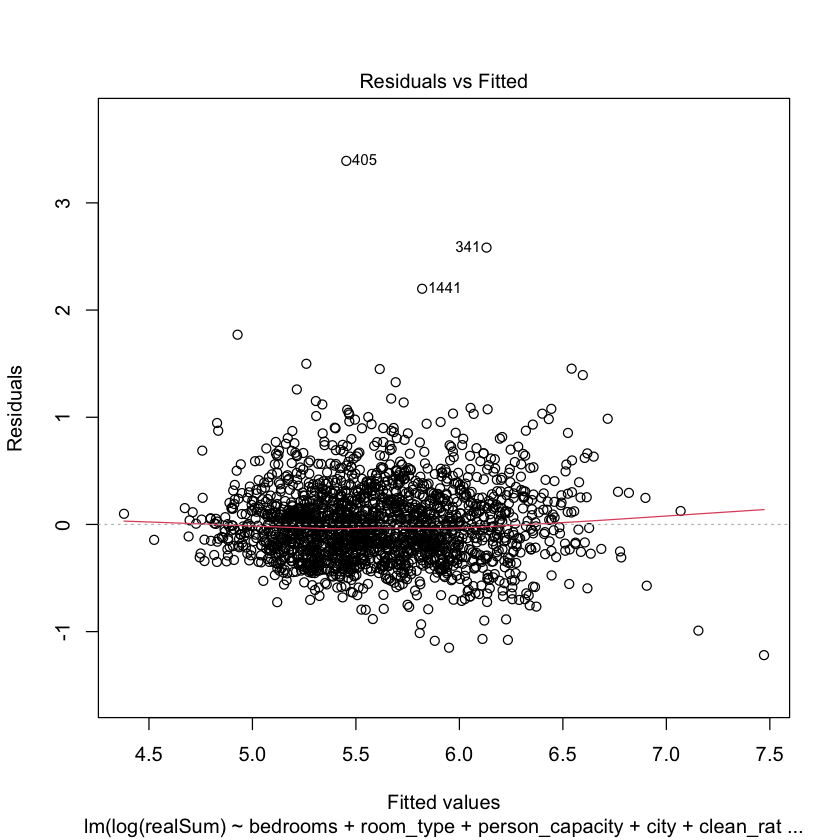

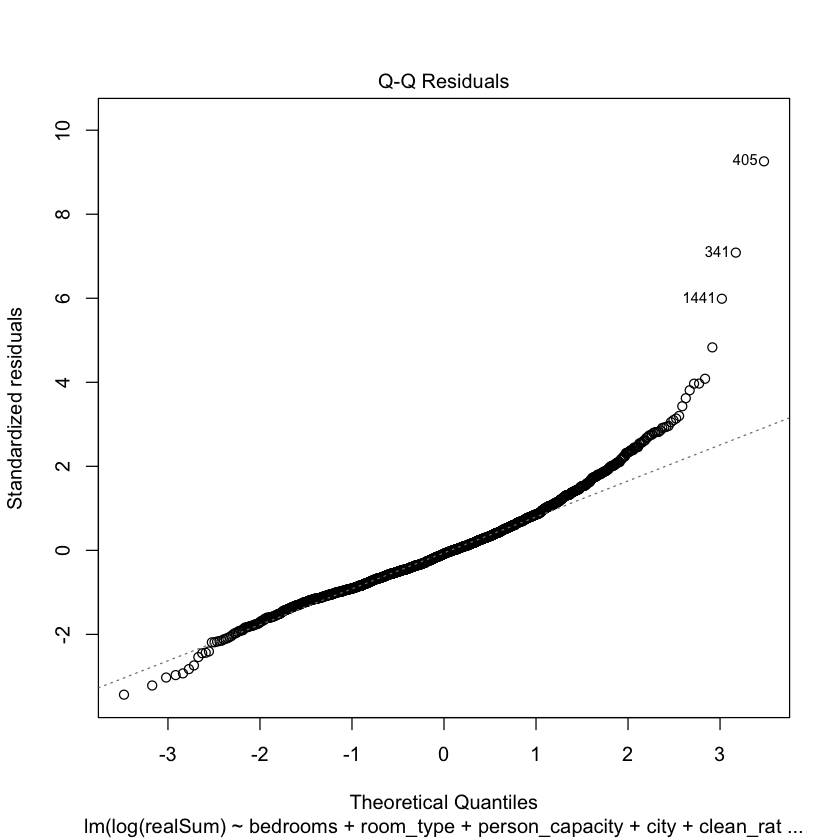

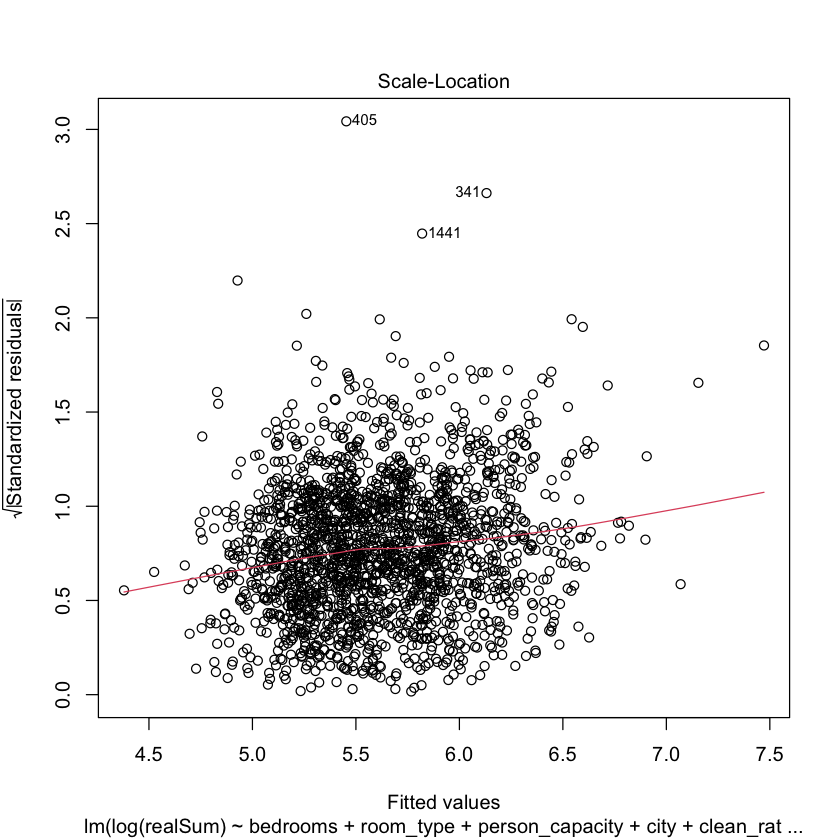

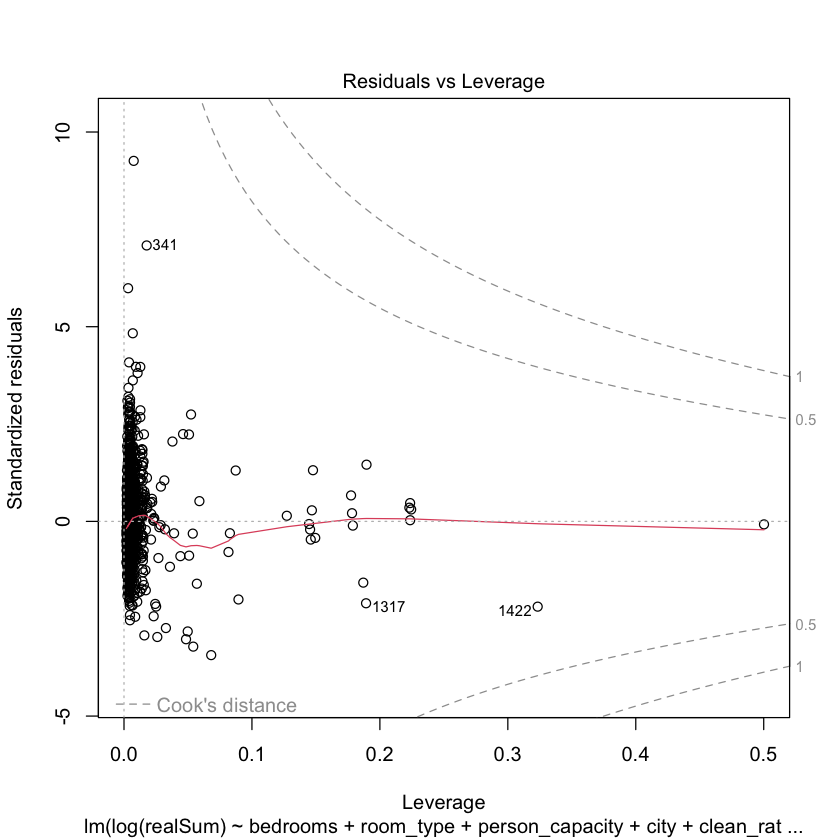

In [218]:
plot(step_aic_inference_centered) 


# Inference explaination